In [1]:
%load_ext line_profiler
import line_profiler

In [2]:
from Cython.Compiler.Options import get_directive_defaults
directive_defaults = get_directive_defaults()
directive_defaults['linetrace'] = True
directive_defaults['binding'] = True#-f --compile-args=-DCYTHON_TRACE=1 # distutils: define_macros=CYTHON_TRACE_NOGIL=1

In [3]:
%load_ext Cython

In [11]:
%%cython -a --compile-args=-DCYTHON_TRACE=1
# cython: profile=True
# cython: linetrace=True
# cython: binding=True


cimport numpy as cnp
import numpy as np
from libc.string cimport strcmp

cnp.import_array()

def get_det(XtX):
    det = (XtX[0, 0]*(XtX[1, 1]*XtX[2, 2] - XtX[1, 2]*XtX[2, 1]) - \
            XtX[1, 0]*(XtX[0, 1]*XtX[2, 2] - XtX[0, 2]*XtX[2, 1]) + \
            XtX[2, 0]*(XtX[1, 2]*XtX[0, 1] - XtX[1, 1]*XtX[0, 2]))
    return det

def linalg_solve(XtX, XtY):
    # by Cramer's rule
    denominator = get_det(XtX)
    num1 = np.array([[XtY[0], XtX[0,1], XtX[0,2]],
                     [XtY[1], XtX[1,1], XtX[1,2]],
                     [XtY[2], XtX[2,1], XtX[2,2]]])
    num2 = np.array([[XtX[0,0], XtY[0], XtX[0,2]],
                     [XtX[1,0], XtY[1], XtX[1,2]],
                     [XtX[2,0], XtY[2], XtX[2,2]]])
    num3 = np.array([[XtX[0,0], XtX[0,1], XtY[0]],
                     [XtX[1,0], XtX[1,1], XtY[1]],
                     [XtX[2,0], XtX[2,1], XtY[2]]])
    """
    sol1 = get_det(np.c_[XtY, XtX[:,1], XtX[:,2]])/denominator # np.c_ not fast
    sol2 = get_det(np.c_[XtX[:,0], XtY, XtX[:,2]])/denominator
    sol3 = get_det(np.c_[XtX[:,0], XtX[:,1], XtY])/denominator
    """
    sol1 = get_det(num1)/denominator # np.c_ not fast
    sol2 = get_det(num2)/denominator
    sol3 = get_det(num3)/denominator

    return np.array([sol1, sol2, sol3])

cpdef best_split(
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    index, # NEW: regression_nodes deleted
    cnp.int64_t n_features,
    # cnp.ndarray[cnp.int64_t, ndim=2] 
    sorted_X_indices,
    # cnp.ndarray[cnp.float64_t, ndim=2] 
    X,
    # cnp.ndarray[cnp.float64_t, ndim=2] 
    y,
    # NEW: char* split_criterion deleted,
    cnp.int64_t min_sample_leaf,
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    k_con,
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    k_lin,
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    k_split_nodes,
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    k_pconc,
    # cnp.ndarray[cnp.int64_t, ndim=1] 
    categorical,
    cnp.int64_t max_features_considered,
    cnp.int64_t min_unique_values_regression,
):
    """
    This function finds the best split as well as the linear
    model on the node.

    parameters:
    -----------
    index: ndarray,
        1D int array. the indices of samples in the current node, which
        would induce sorted_X and sorted_y.
    regression_nodes: list,
        a list indicating which kinds of node is used,
        we have 'lin'/'pcon'/'blin'/'plin'.
    n_features: int,
        number of features.
    sorted_X_indices: ndarray,
        2D int array. Sorted indices of cases, according to each feature.
    X: ndarray,
        2D float array, the predictors.
    y: ndarray,
        2D float array, the response.
    split_criterion: str, TO BE DEPRECATED!!!
        the criterion to split the tree,
        default is 'BIC', can also be 'AIC'/'AICc', etc.
    min_sample_leaf: int,
        the minimal number of samples required
        to be at a leaf node
    k_*: ndarray
        degrees of freedom for each regression node
    categorical: ndarray,
        1D int array, the columns of categorical variable, array.
    max_features_considered: int
        number of features to consider for each split (randomly sampled)
    min_unique_values_regression: int
        minimum number of unique values necessary to consider a linear node

    returns:
    --------
    best_feature: int,
        The feature/predictor id at which the dataset is best split.
        if it is a categorical feature, the second element is a list of values
        indicating the left region.
    best_pivot: float,
        The feature id at which the dataset is best split.
    best_node: str,
        The best regression model.
    lm_L: ndarray,
        1D float array. The linear model on the left node (intercept, coeficents).
    lm_R:  ndarray,
        1D float array. The linear model on the right node (intercept, coeficents).
        for 'lin' and 'con': lm_R is None, all information is included in lm_L
    interval: ndarray,
        1D float array. The range of the training data on this node
    pivot_c: ndarray,
        1D int array. An array of the levels belong to the left node.
        Used if the chosen feature/predictor is categorical.

    Remark:
    -------
    If the input data is not allowed to split, the function will return default
    values.
    """

    # Initialize output variables, should be consistent with the variable type
    cdef double best_pivot = -1.0
    cdef str best_node = ""
    cdef double best_loss = -1.0
    cdef int best_feature = -1
    cdef cnp.ndarray[cnp.float64_t, ndim=1] lm_L = np.array([0.0, 0.0])
    cdef cnp.ndarray[cnp.float64_t, ndim=1]lm_R = np.array([0.0, 0.0])
    cdef cnp.ndarray[cnp.float64_t, ndim=1] interval = np.array([-np.inf, np.inf])

    cdef char* regression_nodes[3] # NEW: TO BE TREATED AS AN INPUT
    regression_nodes[0] = "blin"
    regression_nodes[1] = "pcon"
    regression_nodes[2] = "plin"

    # Initialize the coef and intercept for 'blin'/'plin'/'pcon'
    cdef int l = 3
    cdef cnp.ndarray[cnp.float64_t, ndim=2] coef = np.zeros((l, 2), dtype=np.float64) 
    cdef cnp.ndarray[cnp.float64_t, ndim=2] intercept = np.zeros((l, 2), dtype=np.float64)

    # TODO: define the range of the samples
    cdef int feature_id

    # NEW: INITIALIZE INTERMEDIATE VARIABLES
    cdef cnp.ndarray[cnp.int64_t, ndim=1] idx
    cdef cnp.ndarray[cnp.float64_t, ndim=2] X_sorted
    cdef cnp.ndarray[cnp.float64_t, ndim=2] y_sorted
    cdef cnp.ndarray[cnp.float64_t, ndim=1] possible_p
    cdef int lenp
    cdef int pointer_c = 0 # NEW: BY DEFAULT CATEGORICAL = NP.ARRAY([X.SHAPE[1]]) 
    cdef cnp.ndarray[cnp.int64_t, ndim=1] num
    cdef cnp.ndarray[cnp.float64_t, ndim=2] Moments
    cdef double intercept_con
    cdef double coef_con = 0 # NEW: SHOULD BE FLOAT?
    cdef double rss_1d
    cdef cnp.ndarray[cnp.float64_t, ndim=1] rss = np.zeros(3)
    cdef cnp.ndarray[cnp.float64_t, ndim=1] loss
    cdef double var
    cdef double coef_lin
    cdef double intercept_lin
    cdef cnp.ndarray[cnp.float64_t, ndim=2] XtX
    cdef cnp.ndarray[cnp.float64_t, ndim=2] XtY
    cdef double pre_pivot
    cdef int p
    cdef int i
    cdef double pivot
    cdef double xi
    cdef cnp.ndarray[cnp.float64_t, ndim=1] Moments_add 
    cdef cnp.ndarray[cnp.float64_t, ndim=1] coefs
    cdef int index_min
    # cdef cnp.ndarray[cnp.int8_t, ndim = 1] index_add
    cdef double y_add 
    cdef double y_add2
    cdef int start_position
    cdef int end_position
    cdef int num_add
    cdef double det_check
    cdef cnp.ndarray[cnp.int64_t, ndim=1] sol_position
    cdef cnp.ndarray[cnp.float64_t, ndim=2] aug_mat
    cdef int row
    cdef int row2
    cdef int num_all
    cdef double loss_min_split

    # NEW: INTILIZE VARIABLES FOR THE CATEGORICAL ONLY
    cdef cnp.ndarray[cnp.float64_t, ndim=1] mean_vec 
    cdef cnp.ndarray[cnp.int64_t, ndim=1] num_vec 
    cdef int id # pointer for loops
    cdef cnp.ndarray[cnp.int64_t, ndim=1] mean_idx 
    cdef cnp.ndarray[cnp.float64_t, ndim=1] sum_vec 
    cdef cnp.ndarray[cnp.float64_t, ndim=1] sum_all 
    cdef double rss_cat
    cdef cnp.ndarray[cnp.float64_t, ndim=1] pivot_c = np.array([0.])

    # search for the best split among all features, negelecting the indices column
    for feature_id in range(1, n_features + 1):
        # get sorted X, y NEW: 1D ARRAY?
        idx = sorted_X_indices[feature_id - 1] # NEW: ANNOTATION
        idx = idx[np.isin(idx, index)]
        X_sorted = X[idx] # NEW: ANNOTATION
        y_sorted = y[idx] # NEW: .COPY DROPPED

        # Initialize possible pivots
        possible_p = np.unique(X_sorted[:, feature_id]) # NEW: ANNOTATION
        lenp = possible_p.shape[0] # NEW: ANNOTATION, DROP LEN()

        if feature_id - 1 < categorical[pointer_c]: # NEW: ALL IN FUNCTION NEEDS TO BE OPTIMIZED,
                                              # EITHER NUMPY.ISIN OR EXPLICIT LOOP OR OTHER IMPLEMENTATIONS
            num_all = X_sorted.shape[0]
            num = np.array([0, num_all], dtype = np.int64)

            # initialize the pointer
            start_position = 0
            end_position = 1

            # store entries of the Gram and moment matrices
            Moments = np.array(
                [
                    [0.0, 0.0, 0.0, 0.0, 0.0],
                    [
                        np.sum(X_sorted[:, feature_id]),
                        np.sum(X_sorted[:, feature_id] ** 2),
                        np.sum(X_sorted[:, feature_id].copy().reshape(-1, 1) * y_sorted),
                        np.sum(y_sorted),
                        np.sum(y_sorted**2),
                    ],
                ]
            )

            # CON: NEW DELETE IF CON
            # print(num)
            intercept_con = Moments[1, 3] / num[1]
            # compute the RSS and the loss according to the information criterion
            rss_1d = (
                Moments[1, 4]
                + (num[1] * intercept_con**2)
                - 2 * intercept_con * Moments[1, 3]
            )
            loss = loss_fun(
                # criteria=split_criterion,
                num=num[1],
                Rss=np.array([rss_1d]),
                k=k_con,
            )
            # update best_loss immediately
            if best_node == "" or loss.item() < best_loss: # NEW: THEY ARE ALL DEFINED
                best_node = "con"
                best_loss = loss.item()
                best_feature = feature_id
                interval = np.array([possible_p[0], possible_p[-1]])
                lm_L = np.array([coef_con, intercept_con])

            # LIN: NEW DELETE IF LIN
            if lenp >= min_unique_values_regression:
                var = num[1] * Moments[1, 1] - Moments[1, 0] ** 2 # NEW: FLOAT
                # in case a constant feature
                if var == 0.0:
                    coef_lin = 0.0
                else:
                    coef_lin = (num[1] * Moments[1, 2] - Moments[1, 0] * Moments[1, 3]) / var # NEW: FLOAT
                intercept_lin = (Moments[1, 3] - coef_lin * Moments[1, 0]) / num[1]
                # compute the RSS and the loss according to the information criterion
                rss_1d = (
                    Moments[1, 4]
                    + (num[1] * intercept_lin**2)
                    + (2 * coef_lin * intercept_lin * Moments[1, 0])
                    + coef_lin**2 * Moments[1, 1]
                    - 2 * intercept_lin * Moments[1, 3]
                    - 2 * coef_lin * Moments[1, 2]
                )
                loss = loss_fun(
                    # criteria=split_criterion,
                    num=num[1],
                    Rss=np.array([rss_1d]),
                    k=k_lin,
                )
                # update best_loss immediately
                if best_node == "" or loss.item() < best_loss:
                    best_node = "lin"
                    best_loss = loss.item()
                    best_feature = feature_id
                    interval = np.array([possible_p[0], possible_p[-1]])
                    lm_L = np.array([coef_lin, intercept_lin])

            # For blin, we need to maintain another Gram/moment matrices and the knot xi
            # NEW: ALWAYS BLIN
            # Moments need to be updated for blin:
            # [sum(x-xi)+, sum[(x-xi)+]**2, sum[x(x-xi)+], sum[y(x-xi)+]]
            XtX = np.array(
                [
                    [
                        np.float64(num[1]),
                            Moments[1, 0],
                            Moments[1, 0],
                        ],
                        [Moments[1, 0], Moments[1, 1], Moments[1, 1]],
                        [Moments[1, 0], Moments[1, 1], Moments[1, 1]],
                ]
            )
            XtY = np.array([[Moments[1, 3]], [Moments[1, 2]], [Moments[1, 2]]])
            pre_pivot = 0.0

            # pcon, blin and plin: try each possible split and
            # find the best one the last number are never used for split
            for p in range(possible_p.shape[0] - 1):
                # The pointer to select the column of coef and intercept
                i = 0
                pivot = possible_p[p]
                y_add = y_sorted[start_position]
                y_add2 = y_sorted[start_position]**2
                num_add = 1
                # update cases in the left region
                
                # NEW: DEFINE A POINTER
                while (X[end_position,feature_id] == pivot):
                    y_add += y_sorted[end_position]
                    y_add2 += y_sorted[end_position] ** 2
                    end_position += 1
                    num_add += 1
                else:
                    start_position = end_position
                    end_position += 1

                # BLIN:
                # First maintain xi
                xi = pivot - pre_pivot

                # update XtX and XtY

                """
                    XtX += np.array(
                        [
                            [0.0, 0.0, -xi * num[1]],
                            [0.0, 0.0, -xi * Moments[1, 0]],
                            [
                                -xi * num[1],
                                -xi * Moments[1, 0],
                                xi**2 * num[1] - 2 * xi * XtX[0, 2],
                            ],
                        ]
                    )
                    XtY += np.array([[0.0], [0.0], [-xi * Moments[1, 3]]])
                """

                XtX[0, 2] -= xi * num[1]
                XtX[1, 2] -= xi * Moments[1, 0]
                XtX[2, 0] -= xi * num[1]
                XtX[2, 1] -= xi * Moments[1, 0]
                XtX[2, 2] += xi**2 * num[1] - 2 * xi * XtX[0, 2]
                XtY[2, 0] -= xi * Moments[1, 3]

                # TODO: compute the determinant from scratch
                det_check = get_det(XtX)

                # useless to check the first pivot or partition that
                # leads to less than min_sample_leaf samples
                if (
                    pivot != possible_p[0]
                    and p >= 1
                    and lenp >= min_unique_values_regression
                    and det_check > 0.001
                    and num[0] + num_add >= min_sample_leaf
                    and num[1] - num_add >= min_sample_leaf
                ):  

                    """
                    # solve the linear system by Gauss elimination
                    aug_mat = np.array([[XtX[0, 0], XtX[0, 1], XtX[0, 2],XtY[0]],
                                    [XtX[1, 0], XtX[1, 1], XtX[1, 2],XtY[1]],
                                    [XtX[2, 0], XtX[2, 1], XtX[2, 2],XtY[2]]], dtype = np.float64)
                    sol_position = np.array([-1,-1,-1], dtype = np.int64)
                    
                    # find the position
                    for column in range(3):
                        for row in range(3):
                            if row not in sol_position and aug_mat[row, column] != 0:
                                sol_position[column] = row
                                aug_mat[row, column:] = aug_mat[row, column:]/aug_mat[row, column]
                                for row2 in range(3):
                                    if row2 != row:
                                        aug_mat[row, column:] = aug_mat[row2, column:] - \
                                                                aug_mat[row, column: ] * \
                                                                aug_mat[row2, column]
                                continue
                    coefs = np.array([aug_mat[sol_position[0], 3],aug_mat[sol_position[1], 3],aug_mat[sol_position[2], 3]])
                    """

                    coefs = linalg_solve(XtX, XtY).flatten()                      
                    # coefs = np.linalg.solve(XtX, XtY).flatten()
                    coef[i, :] = np.array([coefs[1], coefs[1] + coefs[2]])
                    intercept[i, :] = np.array([coefs[0], coefs[0] - coefs[2] * pivot])
                i += 1  # we add a dimension to the coef and intercept arrays， i = 1
                pre_pivot = pivot

                # update num after blin is fitted
                num += np.array([1, -1]) * num_add

                # first update moments then check if this pivot is eligable for a pcon/plin split
                
                Moments_add = np.array(
                    [
                        pivot * num_add,
                        pivot**2 * num_add,
                        pivot * y_add,
                        y_add,
                        y_add2,
                    ]
                )
                    
                Moments += Moments_add * np.array([[1.0], [-1.0]])

                # negelect ineligable split
                if num[0] < min_sample_leaf:
                    continue
                elif num[1] < min_sample_leaf:
                    break

                # 'pcon' fit
                coef[i, :] = np.array([0, 0])
                intercept[i, :] = (Moments[:, 3]) / num
                i += 1  # we add a dimension to the coef and intercept arrays i = 2

                # 'plin' for the first split candidate is equivalent to 'pcon'
                if (
                    p
                    >= min_unique_values_regression
                    - 1  # number of unique values smaller than current value
                    and lenp - p
                    >= min_unique_values_regression  # number of unique values larger than current value
                    # and ~np.isin(0., num * Moments[:, 1] - Moments[:, 0] ** 2) # remove constant feature? but unique value > 5 already!
                ):
                    # coef and intercept are vectors of dimension 1
                    # have to reshape X column in order to get correct cross product
                    # the intercept should be divided by the total number of samples
                    coef[i, :] = (num * Moments[:, 2] - Moments[:, 0] * Moments[:, 3]) / (
                        num * Moments[:, 1] - Moments[:, 0] ** 2
                    )
                    intercept[i, :] = (Moments[:, 3] - coef[i, :] * Moments[:, 0]) / num

                # compute the rss and loss of the above 3 methods
                # The dimension rss is between 1 and 3 (depending on the regression_nodes)
                # TODO: HOW TO DEFINE RSS?
                
                """
                rss = (
                    Moments[:, 4]
                    + (num * intercept**2)
                    + (2 * coef * intercept * Moments[:, 0])
                    + coef**2 * Moments[:, 1]
                    - 2 * intercept * Moments[:, 3]
                    - 2 * coef * Moments[:, 2]
                ).sum(axis=1)
                """
                
                rss = np.array([0.,0.,0.], dtype = np.float64)
                # intercept is ?x2
                for row in range(3):
                    rss[row] = Moments[0, 4] + Moments[1, 4]
                    + (num[0] * intercept[row,0]**2) + num[1] * intercept[row,1]**2
                    + (2 * coef[row,0] * intercept[row,0] * Moments[0, 0])
                    + (2 * coef[row,1] * intercept[row,1] * Moments[1, 0])
                    + coef[row,0]**2 * Moments[0, 1]
                    + coef[row,1]**2 * Moments[1, 1]
                    - 2 * intercept[row,0] * Moments[0, 3]
                    - 2 * intercept[row,1] * Moments[1, 3]
                    - 2 * coef[row,0] * Moments[0, 2]
                    - 2 * coef[row,1] * Moments[1, 2]
                

                # update the best loss
                rss = np.maximum(10**-8, rss)
                loss =  (num_all) * np.log(rss / num_all) + np.log(num_all) * k_split_nodes
                loss_min_split = loss[0]
                index_min = 0
                for row in range(2):
                    if loss[row + 1] < loss_min_split:
                        loss_min_split = loss[row + 1]
                        index_min = row + 1

                if (best_node == "" or loss_min_split < best_loss):
                    best_loss = loss_min_split
                    best_node = regression_nodes[index_min].decode('utf-8') # NEW: REGRESSION_NODES modified
                    best_feature = feature_id  # asigned but will not be used for 'lin'
                    interval = np.array([possible_p[0], possible_p[-1]])
                    best_pivot = pivot
                    lm_L = np.array([coef[index_min, 0], intercept[index_min, 0]])
                    lm_R = np.array([coef[index_min, 1], intercept[index_min, 1]])

            continue

        # CATEGORICAL VARIABLES
        mean_vec = np.zeros(lenp)
        num_vec = np.zeros(lenp, dtype = np.int64)
        for id in range(lenp):
            # mean values of the response w.r.t. each level
            mean_vec[id] = np.mean(y_sorted[X_sorted[:, feature_id] == possible_p[id]])
            # number of elements at each level
            num_vec[id] = y_sorted[X_sorted[:, feature_id] == possible_p[id]].shape[0]

        # sort unique values w.r.t. the mean of the responses
        mean_idx = np.argsort(mean_vec)
        num_vec = num_vec[mean_idx]
        sum_vec = mean_vec[mean_idx] * num_vec
        possible_p = possible_p[mean_idx]

        # loop over the sorted possible_p and find the best partition
        num = np.array([0, X_sorted.shape[0]], dtype = np.int64)
        sum_all = np.array([0., np.sum(y_sorted)])
        for id in range(lenp - 1):
            # update the sum and num
            sum_all += np.array([1.0, -1.0]) * sum_vec[id]
            num += np.array([1, -1]) * num_vec[id]
            # find the indices of the elements in the left node, NEW: np.isin
            sub_index = np.isin(X_sorted[:, feature_id], possible_p[: id + 1])
            # compute the rss_cat
            rss_cat = np.sum((y_sorted[sub_index] - sum_all[0] / num[0]) ** 2) + np.sum(
                (y_sorted[~sub_index] - sum_all[1] / num[1]) ** 2
            )
            rss_cat = np.maximum(10**-8, rss_cat)
            loss = loss_fun(
                # criteria=split_criterion,
                num=num.sum(),
                Rss=np.array([rss_cat]),
                k=k_pconc,
            )
            if best_node == "" or loss.item() < best_loss:
                best_feature = feature_id
                best_node = "pconc"
                best_loss = loss.item()
                lm_L = np.array([0, sum_all[0] / num[0]])
                lm_R = np.array([0, sum_all[1] / num[1]])
                pivot_c = possible_p[: id + 1].copy()
                # pivot_c = pivot_c.astype(np.int64)

        # update the pointer
        pointer_c += 1


    result = (best_feature, best_pivot, best_node, lm_L, lm_R, interval, pivot_c)
    """
    print(best_feature)
    print(best_pivot)
    print(best_node)
    print(lm_L)
    print(lm_R)
    print(interval)
    print(pivot_c)
    """

    return result

def loss_fun(int num, 
              # cnp.ndarray[cnp.float64_t, ndim=1] 
              Rss, 
              # cnp.ndarray[cnp.int64_t, ndim = 1] 
              k):
    """
    This function is used to compute the information criteria

    parameters:
    ----------
    criteria: str,
        the information criteria
    num: int,
        total number of samples
    Rss: float,
        the residual sum of squares, can be a vector
    k: ndarray,
        1D int array to describe the degrees of freedom, can be a vector

    return:
    -------
    float: The loss according to the information criteria
    """
    cdef cnp.ndarray[cnp.float64_t, ndim=1] loss
    loss =  num * np.log(Rss / num) + np.log(num) * k

    return loss

Content of stdout:
_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.c
c:\Users\u0149551\Miniconda3\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\u0149551\.ipython\cython\_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.c(7058): warning C4244: '=': conversion from 'npy_intp' to 'int', possible loss of data
C:\Users\u0149551\.ipython\cython\_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.c(7088): warning C4244: '=': conversion from 'npy_intp' to 'int', possible loss of data
   Creating library C:\Users\u0149551\.ipython\cython\Users\u0149551\.ipython\cython\_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.cp38-win_amd64.lib and object C:\Users\u0149551\.ipython\cython\Users\u0149551\.ipython\cython\_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.cp38-win_amd64.exp
Generating code
Finished generating code

In [15]:
profile = line_profiler.LineProfiler(best_split)

range(0, 1)

In [8]:
# prepare input
n_samples = 100
n_features = 50

X = 2 * np.random.rand(n_samples, n_features)
y = (3 * X[:,0]**2 + 2*X[:,8] - X[:,30]**3 ).reshape(-1, 1)
X = np.c_[np.arange(0, n_samples), X]

# index and sorted_X_indices
index = 1 + np.arange(n_samples, dtype = np.int64)
sorted_indices = np.array(
        [
            np.argsort(X[:, feature_id], axis=0).flatten()
            for feature_id in range(1, n_features + 1)
        ]
    )
sorted_X_indices = X[:, 0][sorted_indices].astype(np.int64)

min_sample_leaf = 5
min_sample_alpha = 10
k_con = np.array([1], dtype = np.int64)
k_lin = np.array([2], dtype = np.int64)
k_split_nodes = np.array([5, 5, 7], dtype = np.int64)
k_pconc = np.array([5], dtype = np.int64)
categorical = np.array([n_features + 1], dtype=np.int64)
max_features_considered = n_features
min_unique_values_regression = 5
"""
regression_nodes=['lin','con','plin','blin','pcon']
split_criterion='BIC'
categorical = np.array([-1])
k = np.array([5,5,7])
"""

"\nregression_nodes=['lin','con','plin','blin','pcon']\nsplit_criterion='BIC'\ncategorical = np.array([-1])\nk = np.array([5,5,7])\n"

In [9]:
best_split(index, n_features,sorted_X_indices,X,y,min_sample_leaf,k_con,k_lin,k_split_nodes,k_pconc,categorical,max_features_considered,min_unique_values_regression)

(1,
 -1.0,
 'lin',
 array([ 5.18383377, -1.55732366]),
 array([0., 0.]),
 array([0.00917729, 1.98740667]),
 array([0.]))

In [12]:
profile = line_profiler.LineProfiler(best_split)
profile.runcall(best_split, index, n_features,sorted_X_indices,X,y,min_sample_leaf,k_con,k_lin,k_split_nodes,k_pconc,categorical,max_features_considered,min_unique_values_regression)
profile.print_stats()

c:\Users\u0149551\Miniconda3\lib\site-packages\line_profiler\line_profiler.py:152: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return func(*args, **kw)


Timer unit: 1e-07 s

Total time: 0.528487 s
File: C:\Users\u0149551\.ipython\cython\_cython_magic_cd1d9db66b883ee9a4d2351f8b13d73f907985b3.pyx
Function: best_split at line 41

Line #      Hits         Time  Per Hit   % Time  Line Contents
    41                                           cpdef best_split(
    42                                               # cnp.ndarray[cnp.int64_t, ndim=1] 
    43                                               index, # NEW: regression_nodes deleted
    44                                               cnp.int64_t n_features,
    45                                               # cnp.ndarray[cnp.int64_t, ndim=2] 
    46                                               sorted_X_indices,
    47                                               # cnp.ndarray[cnp.float64_t, ndim=2] 
    48                                               X,
    49                                               # cnp.ndarray[cnp.float64_t, ndim=2] 
    50                                

In [27]:
# pure python
profile = line_profiler.LineProfiler(best_split)
profile.runcall(best_split, index, regression_nodes, n_features, sorted_X_indices, X, y, split_criterion, min_sample_leaf, min_sample_alpha, k, categorical)
profile.print_stats()

Timer unit: 1e-07 s

Total time: 1.14362 s
File: C:\Users\u0149551\AppData\Local\Temp\ipykernel_34404\3079381027.py
Function: best_split at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def best_split(
     5                                               index,
     6                                               regression_nodes,
     7                                               n_features,
     8                                               sorted_X_indices,
     9                                               X,
    10                                               y,
    11                                               split_criterion,
    12                                               min_sample_leaf,
    13                                               min_sample_alpha,
    14                                               k,
    15                                               categorical,
    16      

In [9]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import pandas as pd
import numpy as np

In [10]:
results = pd.read_csv('C:/Workdir/Research/Code/yrc17/Pilot_cython/split_function_computation_time_simulation.csv')

results = results.assign(
    log_t_split = np.log(results['time_elapsed_split']),
    log_n=np.log(results['n_samples']),
    log_p=np.log(results['n_features']),
    log_np=np.log(results['n_features']*results['n_samples']),
    log__nlog_n=np.log(np.log(results['n_samples'])*results['n_samples']),
    log__plog_p=np.log(np.log(results['n_features'])*results['n_features']),
    log__nlog2_n=np.log(results['n_features']*(np.log(results['n_features']))**3),
)

In [12]:
m = OLS(endog=results['log_t_split'], exog=sm.add_constant(results[['log_np']])).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            log_t_split   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 2.192e+05
Date:                Thu, 11 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:33:38   Log-Likelihood:                -360.57
No. Observations:                2000   AIC:                             725.1
Df Residuals:                    1998   BIC:                             736.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5335      0.022   -436.481      0.0

In [14]:
m = OLS(endog=results['log_t_split'], exog=sm.add_constant(results[['log_n', 'log_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            log_t_split   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.959e+05
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:19:25   Log-Likelihood:                 216.43
No. Observations:                2000   AIC:                            -426.9
Df Residuals:                    1997   BIC:                            -410.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.6278      0.017   -581.901      0.0

In [21]:
import matplotlib.pyplot as plt

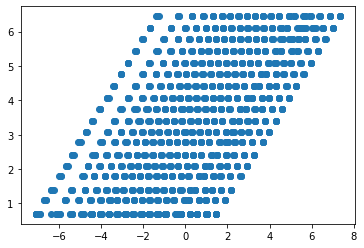

In [22]:
plt.scatter(results['log_t_split'],results[['log_p']])
plt.

In [19]:
m = OLS(endog=results['log_t_split'], exog=sm.add_constant(results[['log__nlog_n', 'log_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            log_t_split   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.242e+05
Date:                Fri, 22 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:34:13   Log-Likelihood:                 718.17
No. Observations:                2000   AIC:                            -1430.
Df Residuals:                    1997   BIC:                            -1414.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -10.1856      0.014   -750.289      

In [16]:
m = OLS(endog=results['log_t_split'], exog=sm.add_constant(results[['log_p']])).fit()

print(m.summary())

                            OLS Regression Results                            
Dep. Variable:            log_t_split   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.376
Method:                 Least Squares   F-statistic:                     1206.
Date:                Fri, 22 Mar 2024   Prob (F-statistic):          4.02e-207
Time:                        11:22:55   Log-Likelihood:                -4595.5
No. Observations:                2000   AIC:                             9195.
Df Residuals:                    1998   BIC:                             9206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.0729      0.109    -28.094      0.0